In [53]:
import numpy as np
import pandas as pd
from scipy.stats import norm
from scipy.optimize import brentq
import matplotlib.pylab as plt
import datetime as dt
from scipy.optimize import least_squares

In [54]:
rate_df = pd.read_csv('discount.csv')
call_df = pd.read_csv("goog_call.csv")
put_df = pd.read_csv("goog_put.csv")

In [55]:
today = dt.date(2013, 8, 30)
expiry = dt.date(2015, 1, 17)
T = (expiry-today).days/365.0
r = np.interp((expiry - today).days, rate_df['Day'], rate_df['Rate (%)'])/100

In [56]:
S = 846.9
beta = 0.8
F = S * np.exp(r*T)

In [57]:
# get the mid price of bid/offer as option price
call_df['mid'] = (call_df['best_bid'] + call_df['best_offer']) / 2
put_df['mid'] = (put_df['best_bid'] + put_df['best_offer']) / 2

In [58]:
def BlackScholesCall(S, K, r, sigma, T):
    d1 = (np.log(S/K)+(r+sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return S*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)

In [59]:
def impliedCallVolatility(S, K, r, price, T):
    impliedVol = brentq(lambda x: price -
                        BlackScholesCall(S, K, r, x, T),
                        1e-6, 1)

    return impliedVol

In [60]:
def BlackScholesPut(S, K, r, sigma, T):
    d1 = (np.log(S/K)+(r+sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return K*np.exp(-r*T)*norm.cdf(-d2) - S*norm.cdf(-d1)

def impliedPutVolatility(S, K, r, price, T):
    impliedVol = brentq(lambda x: price -
                        BlackScholesPut(S, K, r, x, T),
                        1e-6, 1)

    return impliedVol

In [61]:
impliedPutVolatility(800.95,60,0.01,20,0.25)

ValueError: f(a) and f(b) must have different signs

In [62]:
put_df

,date,expiry,strike,best_bid,best_offer,mid
0,20130830,20150117,320,0.90,2.00,1.450
1,20130830,20150117,340,0.15,2.30,1.225
2,20130830,20150117,350,0.80,2.45,1.625
3,20130830,20150117,360,0.60,2.65,1.625
4,20130830,20150117,370,0.65,2.85,1.750
...,...,...,...,...,...,...
117,20130830,20150117,1330,486.50,489.60,488.050
118,20130830,20150117,1340,496.10,499.30,497.700
119,20130830,20150117,1350,505.80,508.70,507.250
120,20130830,20150117,1360,515.00,518.90,516.950


In [63]:
call_df

,date,expiry,strike,best_bid,best_offer,mid
0,20130830,20150117,320,525.3,528.8,527.05
1,20130830,20150117,340,505.8,509.2,507.50
2,20130830,20150117,350,496.0,499.2,497.60
3,20130830,20150117,360,486.3,489.4,487.85
4,20130830,20150117,370,476.5,479.7,478.10
...,...,...,...,...,...,...
117,20130830,20150117,1330,5.7,9.0,7.35
118,20130830,20150117,1340,5.3,8.6,6.95
119,20130830,20150117,1350,5.7,8.2,6.95
120,20130830,20150117,1360,5.5,7.8,6.65


In [64]:
# focus on the out of the money put and out of the money call
put_df_option = put_df[put_df['strike'] <= F]
call_df_option = call_df[call_df['strike'] >= F]
put_df_option

,date,expiry,strike,best_bid,best_offer,mid
0,20130830,20150117,320,0.90,2.00,1.450
1,20130830,20150117,340,0.15,2.30,1.225
2,20130830,20150117,350,0.80,2.45,1.625
3,20130830,20150117,360,0.60,2.65,1.625
4,20130830,20150117,370,0.65,2.85,1.750
...,...,...,...,...,...,...
60,20130830,20150117,830,92.30,93.20,92.750
61,20130830,20150117,835,94.40,95.80,95.100
62,20130830,20150117,840,97.10,98.30,97.700
63,20130830,20150117,845,99.90,100.90,100.400


In [34]:
call_df_option['impliedvol'] = call_df_option.apply(lambda x: impliedCallVolatility(S, x['strike'],r,  x['mid'], T), axis=1)

/Users/ankitrawat/.local/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [35]:
put_df_option['impliedvol'] = put_df_option.apply(lambda x: impliedPutVolatility(S, x['strike'],r,  x['mid'], T), axis=1)

/Users/ankitrawat/.local/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [36]:
df = pd.concat([put_df_option, call_df_option])

In [37]:
def SABR(F, K, T, alpha, beta, rho, nu):
    X = K
    # if K is at-the-money-forward
    if abs(F - K) < 1e-12:
        numer1 = (((1 - beta)**2)/24)*alpha*alpha/(F**(2 - 2*beta))
        numer2 = 0.25*rho*beta*nu*alpha/(F**(1 - beta))
        numer3 = ((2 - 3*rho*rho)/24)*nu*nu
        VolAtm = alpha*(1 + (numer1 + numer2 + numer3)*T)/(F**(1-beta))
        sabrsigma = VolAtm
    else:
        z = (nu/alpha)*((F*X)**(0.5*(1-beta)))*np.log(F/X)
        zhi = np.log((((1 - 2*rho*z + z*z)**0.5) + z - rho)/(1 - rho))
        numer1 = (((1 - beta)**2)/24)*((alpha*alpha)/((F*X)**(1 - beta)))
        numer2 = 0.25*rho*beta*nu*alpha/((F*X)**((1 - beta)/2))
        numer3 = ((2 - 3*rho*rho)/24)*nu*nu
        numer = alpha*(1 + (numer1 + numer2 + numer3)*T)*z
        denom1 = ((1 - beta)**2/24)*(np.log(F/X))**2
        denom2 = (((1 - beta)**4)/1920)*((np.log(F/X))**4)
        denom = ((F*X)**((1 - beta)/2))*(1 + denom1 + denom2)*zhi
        sabrsigma = numer/denom

    return sabrsigma

In [38]:
def sabrcalibration(x, strikes, vols, F, T):
    err = 0.0
    for i, vol in enumerate(vols):
        err += (vol - SABR(F, strikes[i], T,
                           x[0], beta, x[1], x[2]))**2

    return err

In [39]:
initialGuess = [0.02, 0.2, 0.1]
res = least_squares(lambda x: sabrcalibration(x,
                                              df['strike'],
                                              df['impliedvol'],
                                              F,
                                              T),
                    initialGuess)
alpha = res.x[0]
rho = res.x[1]
nu = res.x[2]

In [40]:
print('Calibrated SABR model parameters: alpha = %.3f, beta = %.1f, rho = %.3f, nu = %.3f' % (alpha, beta, rho, nu))

Calibrated SABR model parameters: alpha = 0.991, beta = 0.8, rho = -0.285, nu = 0.352


In [41]:
df['sabrsigma'] = df.apply(lambda x : SABR(F, x['strike'], T, alpha, beta, rho, nu), axis = 1)
df

,date,expiry,strike,best_bid,best_offer,mid,impliedvol,sabrsigma
0,20130830,20150117,320,0.90,2.00,1.450,0.393102,0.368805
1,20130830,20150117,340,0.15,2.30,1.225,0.361520,0.361070
2,20130830,20150117,350,0.80,2.45,1.625,0.365782,0.357384
3,20130830,20150117,360,0.60,2.65,1.625,0.355104,0.353810
4,20130830,20150117,370,0.65,2.85,1.750,0.348660,0.350344
...,...,...,...,...,...,...,...,...
117,20130830,20150117,1330,5.70,9.00,7.350,0.240758,0.241277
118,20130830,20150117,1340,5.30,8.60,6.950,0.240881,0.241287
119,20130830,20150117,1350,5.70,8.20,6.950,0.243821,0.241307
120,20130830,20150117,1360,5.50,7.80,6.650,0.244487,0.241335


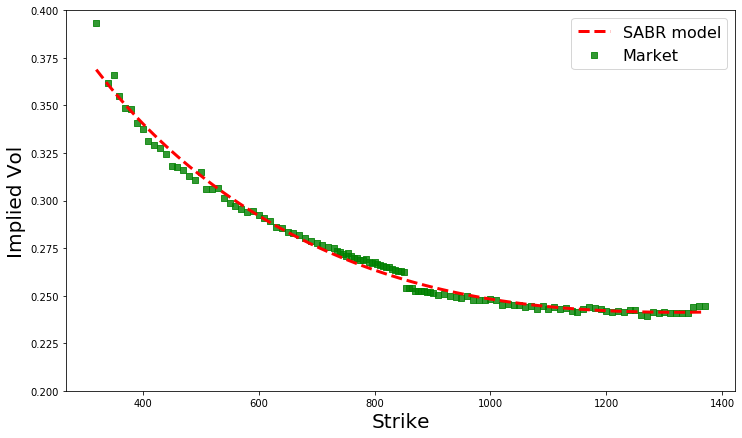

In [42]:
plt.figure(figsize = (12, 7))
plt.scatter(df['strike'],df['impliedvol'], alpha = 0.8, c = 'g' ,marker = 's', label = 'Market')
plt.plot(df['strike'], df['sabrsigma'], '--r', linewidth = 3, label = 'SABR model')
plt.ylabel('Implied Vol', fontsize = 20)
plt.xlabel('Strike', fontsize = 20)
plt.ylim(0.2, 0.4)
plt.legend(fontsize = 16);

Calibrated SABR model parameters: alpha = 0.671, beta = 0.8, rho = 0.141, nu = 0.279


<Figure size 864x504 with 0 Axes>

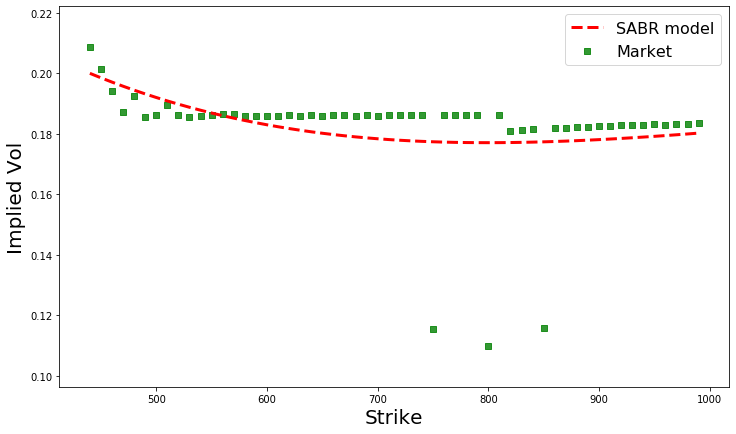

In [66]:
beta = 0.8
df_call_a = pd.read_csv("call.csv")
df_put_a = pd.read_csv("put.csv")
df_call_a = df_call_a[["Date","Expiry","Settle Price","Strike Price","futures_price"]].sort_values(by ="Date")
df_put_a =df_put_a[["Date","Expiry","Settle Price","Strike Price","futures_price"]].sort_values(by ="Date")
df_put_a
def time_to_expiry(opt):
    opt.Expiry = pd.to_datetime(opt.Expiry)
    opt.Date = pd.to_datetime(opt.Date)
    opt['time_to_expiry'] = ((opt.Expiry - opt.Date).dt.days)/365
    return opt

df_call_a = time_to_expiry(df_call_a)
df_put_a = time_to_expiry(df_put_a)
df_put_a = df_put_a[df_put_a['Strike Price'] <= df_put_a['futures_price']]
df_call_a = df_call_a[df_call_a['Strike Price'] >= df_call_a['futures_price']]
df_call_a = df_call_a[df_call_a["Date"]=="2021-01-11"]
df_put_a =  df_put_a[df_put_a["Date"]=="2021-01-11"]
def BlackScholesCall(S, K, r, sigma, T):
    d1 = (np.log(S/K)+(r+sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return S*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)

def BlackScholesPut(S, K, r, sigma, T):
    d1 = (np.log(S / K) + (r + sigma ** 2 / 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)


def impliedCallVolatility(S, K, r, price, T):
    impliedVol = brentq(lambda x: price -
                        BlackScholesCall(S, K, r, x, T),
                        1e-6, 1)

    return impliedVol


def impliedPutVol(S, K, r, price, T):
    impliedVolput = brentq(lambda x: price -
                              BlackScholesPut(S, K, r, x, T),1e-6, 1)
    return impliedVolput


df_call_a['impliedvol'] = df_call_a.apply(lambda x: impliedCallVolatility(x['futures_price'], x['Strike Price'],0,  x['Settle Price'], x['time_to_expiry']), axis=1)
df_put_a['impliedvol'] = df_put_a.apply(lambda x: impliedPutVol(x['futures_price'], x['Strike Price'],0,  x['Settle Price'], x['time_to_expiry']), axis=1)
df = pd.concat([df_call_a,df_put_a])

def SABR(F, K, T, alpha, beta, rho, nu):
    X = K
    # if K is at-the-money-forward
    if abs(F - K) < 1e-12:
        numer1 = (((1 - beta)**2)/24)*alpha*alpha/(F**(2 - 2*beta))
        numer2 = 0.25*rho*beta*nu*alpha/(F**(1 - beta))
        numer3 = ((2 - 3*rho*rho)/24)*nu*nu
        VolAtm = alpha*(1 + (numer1 + numer2 + numer3)*T)/(F**(1-beta))
        sabrsigma = VolAtm
    else:
        z = (nu/alpha)*((F*X)**(0.5*(1-beta)))*np.log(F/X)
        zhi = np.log((((1 - 2*rho*z + z*z)**0.5) + z - rho)/(1 - rho))
        numer1 = (((1 - beta)**2)/24)*((alpha*alpha)/((F*X)**(1 - beta)))
        numer2 = 0.25*rho*beta*nu*alpha/((F*X)**((1 - beta)/2))
        numer3 = ((2 - 3*rho*rho)/24)*nu*nu
        numer = alpha*(1 + (numer1 + numer2 + numer3)*T)*z
        denom1 = ((1 - beta)**2/24)*(np.log(F/X))**2
        denom2 = (((1 - beta)**4)/1920)*((np.log(F/X))**4)
        denom = ((F*X)**((1 - beta)/2))*(1 + denom1 + denom2)*zhi
        sabrsigma = numer/denom

    return sabrsigma

def sabrcalibration(x, strikes, vols, F, T):
    err = 0.0
    for i, vol in enumerate(vols):
        err += (vol - SABR(F, strikes[i], T,
                           x[0], beta, x[1], x[2]))**2

    return err

initialGuess = [0.02, 0.2, 0.1]
res = least_squares(lambda x: sabrcalibration(x,df["Strike Price"].values,df["impliedvol"].values,810.7,0.967123),initialGuess)
alpha = res.x[0]
rho = res.x[1]
nu = res.x[2]
print('Calibrated SABR model parameters: alpha = %.3f, beta = %.1f, rho = %.3f, nu = %.3f' % (alpha, beta, rho, nu))

df['sabrsigma'] = df.apply(lambda x : SABR(x['futures_price'], x["Strike Price"], 0.967123, alpha, beta, rho, nu), axis = 1)
plt.figure(figsize = (12, 7))
df = df[['Strike Price','sabrsigma','impliedvol']].sort_values(by ="Strike Price")

plt.figure(figsize = (12, 7))
plt.scatter(df['Strike Price'],df['impliedvol'], alpha = 0.8, c = 'g' ,marker = 's', label = 'Market')
plt.plot(df['Strike Price'], df['sabrsigma'], '--r', linewidth = 3, label = 'SABR model')
plt.ylabel('Implied Vol', fontsize = 20)
plt.xlabel('Strike', fontsize = 20)
plt.legend(fontsize = 16);

In [67]:
df

,Strike Price,sabrsigma,impliedvol
0,440,0.199974,0.208533
37,450,0.198493,0.201319
1,460,0.197074,0.194258
2,470,0.195715,0.187341
3,480,0.194416,0.192601
4,490,0.193174,0.185562
5,500,0.191989,0.186205
6,510,0.190859,0.189583
7,520,0.189783,0.186292
8,530,0.188759,0.185518
